In [1]:
from cppbridge import *
from mcmc_analytics import *

In [2]:
%load_ext autoreload
%autoreload 2

# Inferring parameters with single-state Metropolitan and EHMM samplers for linear Gaussian models

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification
Here we will try to recover the parameters of the same LG-SSM we used in the experiments with linear Gaussian models with known parameters (see `testing_samplers.ipynb` notebook). To do that we will specify the priors for each of the parameters driving the model: $a_i$ and $\rho$ for transition model and $c_i$ and variance in $\mathbf R$ for the observation model.

Out chosen priors are as follows:
* $a_{i}\sim\mathrm{U}(-1,1)$: for VAR(1) process we need our coefficients to be between -1 and 1
* $\rho\sim\mathrm{U}(0,1)$
* $c_{i}\sim\mathcal{N}(0,\sigma^{2})$, where $\sigma^{2}$ is a large number to make the prior vague
* $r_{i}\sim\mathrm{IGa}(\alpha,\beta)$, where $\mathrm{IGa}$ is the inverse Gamma distribution; we choose $\alpha$ and $\beta$ such that the mean is close to 1 and variance is fairly large

In [3]:
# Set up the transition model with unknown parameters
T = 250
n = 10
A = DiagonalMatrixParam()
aa = -1
bb = 1.
A.parametrize(n, DistributionType.UNIFORM, (aa, bb), minx=aa, maxx=bb, varscale=4)
Q = SymmetricMatrixParam()
a = 0.
b = 1.
x_var = 1.
Q.parametrize(n, DistributionType.UNIFORM, (a, b), x_var, minx=a, maxx=b)
# Prior mean is always zero
prior_mean = np.zeros(n)
# The prior covariance will be re-calculated for each newly accepted parameters, including for the first iteration 
# so below will not be used but still required to intialize the class 
Q_init = np.eye(n)
trm = TransitionSpec(A, Q, prior_mean, Q_init)

In [4]:
# Set up the observation model with unknown parameters
C = DiagonalMatrixParam()
mu = -1
var = 4
C.parametrize(n, DistributionType.NORMAL, (mu, np.sqrt(var)))
R = DiagonalMatrixParam()
rmean = 1.
alpha = 2 + (rmean**2)/var
beta = (alpha - 1) * rmean
R.parametrize(n, DistributionType.INVGAMMA, (alpha, 1/beta), minx=0, maxx=np.inf)
obsm = ObservationSpec(ModelType.LINEAR_GAUSS, C, R)

Make sure the second parameter of Inverse Gamma distribution is the reciprocal of the scale.


In [5]:
# Here we specify the tru values of the parameters:
params_names = ["$a$", "$\\rho$", "$c$", "$r$"]
true_values = dict(zip(params_names, [0.9, 0.7, -0.4, 1.0]))

## Sampler specification
### Embedded HMM sampling scheme
In these experiments we will only be using EHMM sampler.

In [6]:
# Specify EHMM scheme
nupd = 50  # number of parameter updates between the scheme runs
pool_sz = 50
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz, num_parameter_updates=nupd)

## Observations
We need the observations, on which to run the samplers. The data we use is the synthetic data, generated in `models.ipynb` notebook. In this experiemtns we will try and recover the parameters used to generate that data as well as the latent states.

In [7]:
model = "gauss_gauss_279286109056929515"
dataprovider = model + "_data.h5"
dataspec = Data(dataprovider)

## Simulation    
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ and run 5 simulations for $10 000$ iterations each, starting with the different seed for randomisation.

In [8]:
n_iter_ehmm = 10000
x_init = np.zeros((n, T))
seeds = np.array([1, 3, 5, 7, 9], dtype=int)
scales_ehmm = np.array([0.1, 0.5, 0.03, 0.015])
reverse = False
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [9]:
# Simulation with EHMM sampler
ehmm_session_name = f"lg_paramsampl_ehmm50_noreverse"
mcmc_ehmm_lg = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lg.hasResults():
    mcmc_ehmm_lg.loadResults()
else:
    mcmc_ehmm_lg.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lg.run()

Loading results for seed9...		Done
Loading results for seed7...		Done
Loading results for seed3...		Done
Loading results for seed1...		Done
Loading results for seed5...		Done


## Kalman smoother
To check the results the samplers return we use means from Kalman smoother run previously

In [10]:
kalman_session_name = "kalman_10x250_v1"
kalman_lg = KalmanSession(kalman_session_name)
kalman_lg.loadResults()

---
## Analysis of the results
### Overview

In [11]:
nsamples = (1 + reverse) * (n_iter_ehmm + 1)
ehmm_burnin = int(0.1 * nsamples)
psamples = mcmc_ehmm_lg.getParamSamples(ehmm_burnin, params_names)
ehmm_samples = mcmc_ehmm_lg.getSamples(ehmm_burnin)

In [67]:
ac_ehmm = getACF(mcmc_ehmm_lg.samples, ehmm_samples, lags=nsamples-1)
taus_ehmm = 1 + 2 * np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

In [68]:
allpsamples = {k:v[:,np.newaxis] for k, v in mcmc_ehmm_lg.param_samples.items()}
ac_params = getACF(allpsamples, psamples.values[:,np.newaxis], lags=nsamples-1)
taus_params = 1 + 2 * np.sum(ac_params, axis=2)
meantaus_params = np.mean(taus_params)

In [69]:
ehmm_met_acc = 100 * np.mean(
    [acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lg.acceptances.items()])
ehmm_shift_acc = 100 * np.mean(
    [acc[T + 1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lg.acceptances.items()])
ehmm_partrm_acc = 100 * np.mean([acc['trm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_lg.param_acceptances.items()])
ehmm_parobm_acc = 100 * np.mean([acc['obsm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_lg.param_acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                 "Num iter": n_iter_ehmm,
                 "Time per sample, ms": np.mean(list(mcmc_ehmm_lg.durations.values())) /
                                        list(mcmc_ehmm_lg.samples.values())[0].shape[0],
                 "Acceptance rate, autoregressive update, %": ehmm_met_acc,
                 "Acceptance rate, shift update, %": ehmm_shift_acc,
                 "Acceptance rate, param updates for transition model, %": ehmm_partrm_acc,
                 "Acceptance rate, param updates for observation model, %": ehmm_parobm_acc,
                 "Average autocorrelation time, states": meantaus_ehmm,
                 "Average autocorrelation time, params": meantaus_params
                 }
overview = pd.DataFrame({"EHMM on LG-SSM": ehmm_overview})
overview

,EHMM on LG-SSM
"Acceptance rate, autoregressive update, %",82.260648
"Acceptance rate, param updates for observation model, %",25.747080
"Acceptance rate, param updates for transition model, %",26.000240
"Acceptance rate, shift update, %",53.185227
"Average autocorrelation time, params",108.207292
"Average autocorrelation time, states",11.440122
Num iter,10000.000000
Num seeds,5.000000
"Time per sample, ms",59.175022


In [70]:
ehmm_ar = np.stack(list(mcmc_ehmm_lg.acceptances.values()), axis=1)[:T].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_lg.acceptances.values()), axis=1)[T + 1:].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
trm_pacc = np.array([accr['trm'] for seed, accr in mcmc_ehmm_lg.param_acceptances.items()]) / (n_iter_ehmm * nupd * (1 + reverse)) 
obm_pacc = np.array([accr['obsm'] for seed, accr in mcmc_ehmm_lg.param_acceptances.items()]) / (n_iter_ehmm * nupd * (1 + reverse)) 
states = pd.DataFrame(dict(ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan] * len(seeds)))).describe()
params = pd.DataFrame(dict(trm_params=trm_pacc, obm_params=obm_pacc)).describe()
pd.concat([states, params], axis=1)

,ehmm_ar,ehmm_shift,trm_params,obm_params
count,1250.000000,1245.000000,5.000000,5.000000
mean,0.822606,0.531852,0.260002,0.257471
std,0.025088,0.058294,0.005926,0.001339
min,0.660100,0.347090,0.254650,0.255160
25%,0.813614,0.492142,0.256772,0.257738
50%,0.827704,0.537522,0.258536,0.257750
75%,0.838969,0.575610,0.260090,0.258106
max,0.866628,0.670208,0.269964,0.258600


### Test equality of means

In [17]:
# Check one of the particles for all plots below
t = 235
d = 4

### Test equality of parameters

In [72]:
params_ttest = ttest(psamples, list(true_values.values()))
pd.DataFrame({"p-value":params_ttest}, index=params_names)

,p-value
$a_i$,0.0
$\rho$,0.0
$c_i$,0.0
$r_i$,0.0


In [73]:
pd.DataFrame({"means":psamples.mean(axis=0), "variances": psamples.var(axis=0)}, index=params_names).T 

,$a_i$,$\rho$,$c_i$,$r_i$
means,0.883303,0.648588,-0.45328,0.959684
variances,0.000323,0.002709,0.00094,0.001305


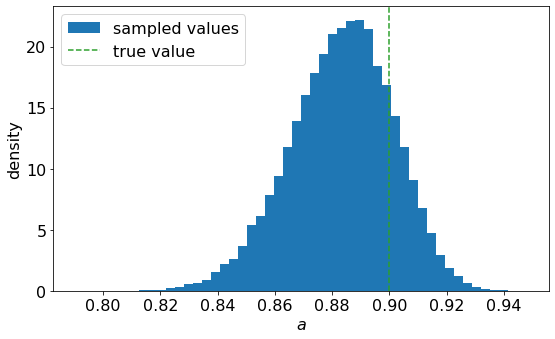

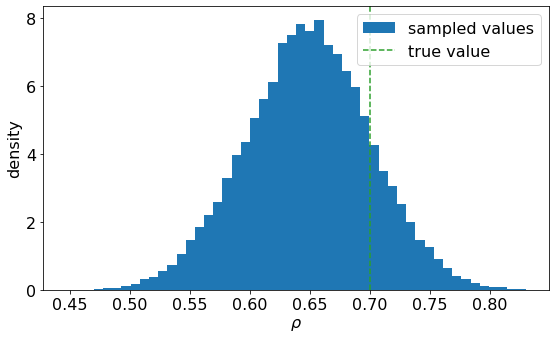

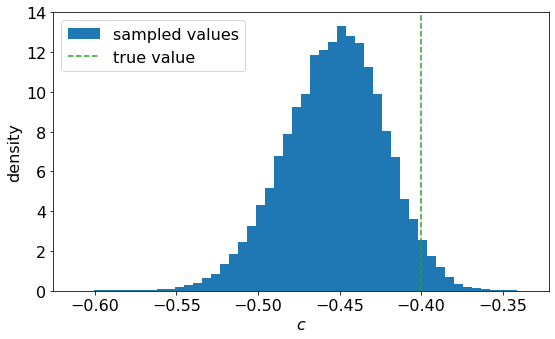

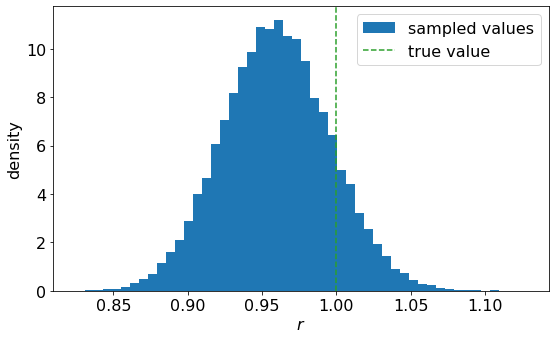

In [16]:
for pname in params_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(psamples[pname], bins=50, density=True, label=f"sampled values")
    ax.vlines(true_values[pname], 0, 1, transform=ax.get_xaxis_transform(), label="true value", linestyles='dashed', color="C2")
    ax.set_ylabel("density")
    ax.set_xlabel(pname)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"lg_{pname.strip('$')}_hist.png", dpi=150, format='png')
    plt.show()

### Convergence analysis

In [75]:
epsr = getEPSR(mcmc_ehmm_lg.samples, ehmm_burnin)

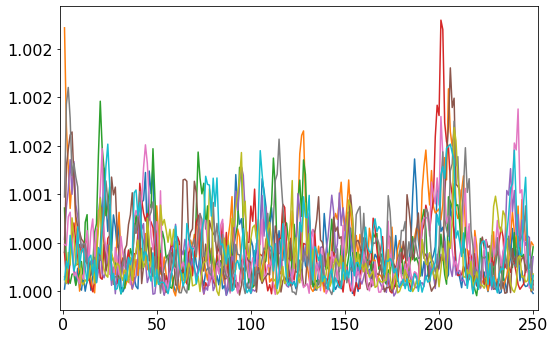

In [78]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr[:, i])
ax.set_xmargin(0.01)
ax.locator_params(axis='y', nbins=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# for i, tick in enumerate(ax.yaxis.get_ticklabels()):
#     if i % 2 != 0:
#         tick.set_visible(False) 
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"epsr_met_lp.png", dpi=300, format='png')
plt.show();

In [77]:
epsr_params = getEPSR(mcmc_ehmm_lg.param_samples, ehmm_burnin)
pd.DataFrame({"EPSR": epsr_params}, index=params_names)

,EPSR
$a_i$,1.005641
$\rho$,1.003979
$c_i$,1.004413
$r_i$,1.001707


### Autocorrelation

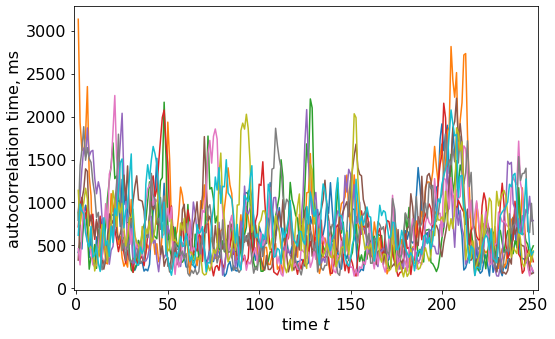

In [79]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus_ehmm[i, :]*overview.loc['Time per sample, ms', 'EHMM on LG-SSM'])
ax.set_xmargin(0.01)
ax.set_xlabel("time $t$")
ax.set_ylabel("autocorrelation time, ms")
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"taus_ehmm_lp.png", dpi=300, format='png')
plt.show();

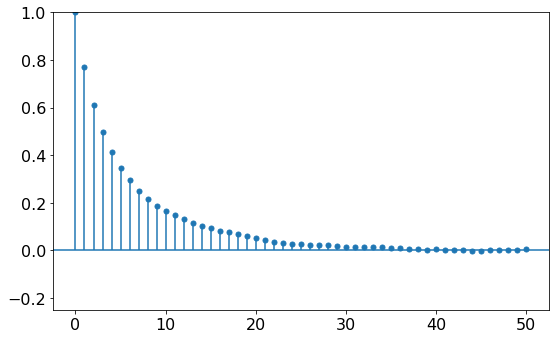

In [82]:
fig, ax = plt.subplots(figsize=(8,5))
plotACF(ac_ehmm, t, d, ax, nlags=50)
ax.set_ylim(-0.25,1)
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/f"acf_ehmm_{t}-{d}_lp.png", dpi=300, format='png')
plt.show();

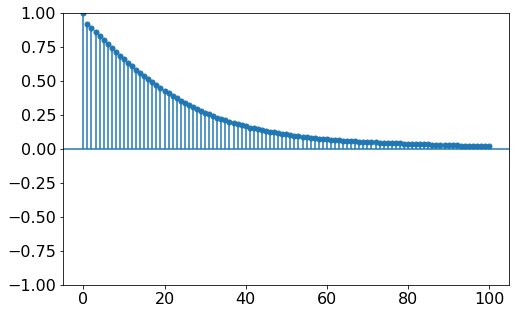

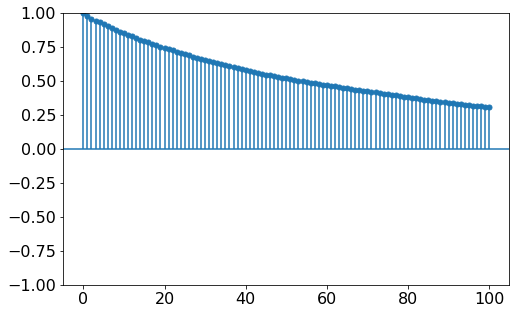

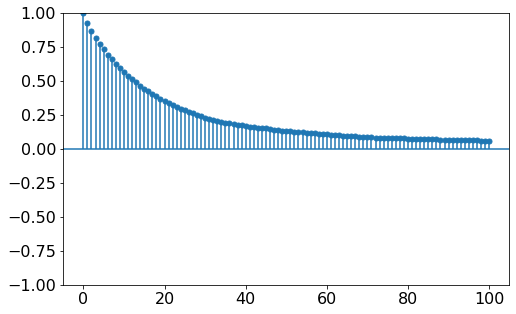

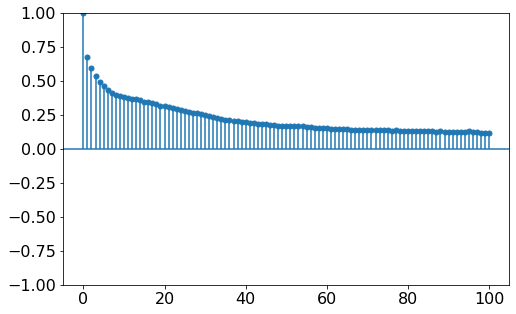

In [84]:
for idx, _ in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))
    plotACF(ac_params, 0, idx, ax, nlags=100)

### Trace plots

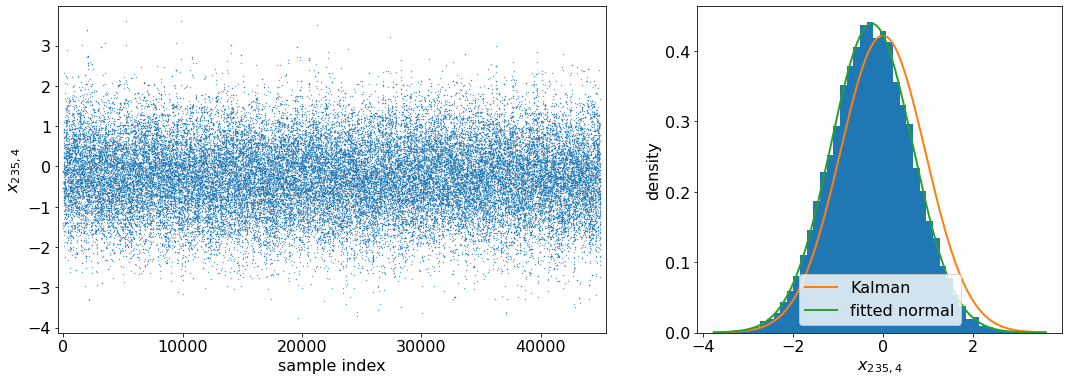

{'exact': {'mean': -0.00693693144280233, 'st.dev.': 0.945532335509045},
 'fitted': {'mean': -0.25176347623081435, 'st.dev.': 0.9091192137811743}}

In [19]:
plotTrace(ehmm_samples, t, d, fitnorm=True, kalman=kalman_lg, save="paraminf_lg")

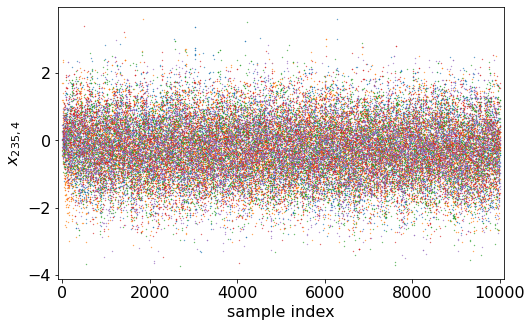

In [21]:
plotMixing(mcmc_ehmm_lg.samples, t, d, save="paraminf_lg")

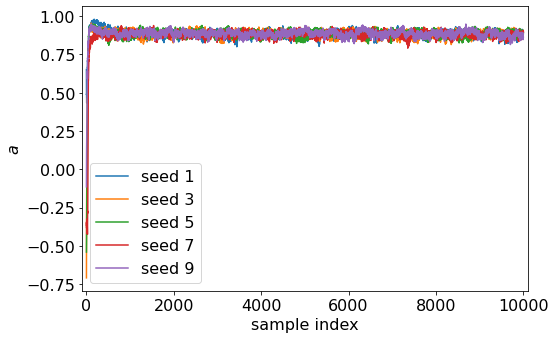

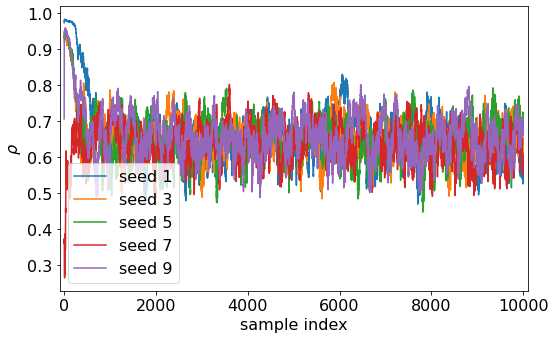

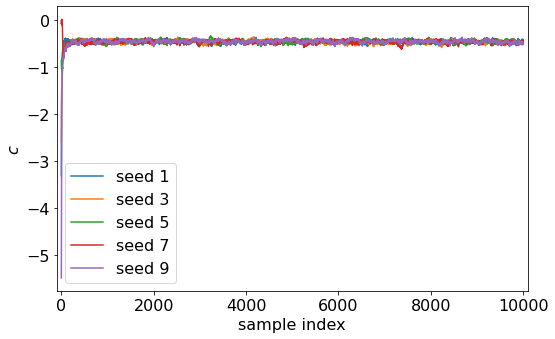

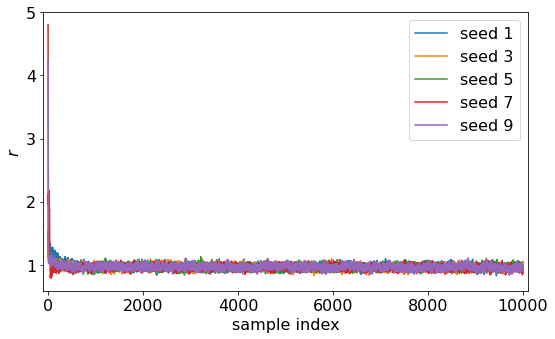

In [12]:
for idx, param_name in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))

    for seed in seeds:
        data = mcmc_ehmm_lg.getParamSamples(0, params_names, forseed=seed)
        ax.plot(data.index, data[param_name], label=f"seed {seed}")

    ax.set_xmargin(0.01)
    ax.set_ylabel(param_name)
    ax.set_xlabel("sample index")
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / f"paraminf_lg_plotmix_{param_name.strip('$')}.png", dpi=150, format='png')
    plt.show()

### Comparison of tuning 

In [51]:
datadict = defaultdict(dict)
for item in DATA_PATH.iterdir():
    fn = str(item).split("/")[-1]
    if fn.startswith("paramtune"):
        spec = "-".join(fn.split("_")[1:5])
        if fn.endswith('specs.h5'):
            coldict = {}
            with h5py.File(item, 'r') as f: 
                coldict[('model','A mean')] = f['model/transition/A'][4:6].mean()
                coldict[('model','A var')] = (f['model/transition/A'][5] - f['model/transition/A'][4])**2 / 12
                coldict[('model','A varscale')] = f['model/transition/A'][3]
                coldict[('model','Q mean')] = f['model/transition/Q'][4:6].mean()
                coldict[('model','Q var')] = (f['model/transition/Q'][5] - f['model/transition/Q'][4])**2 / 12
                coldict[('model','Q varscale')] = f['model/transition/Q'][3]
                coldict[('model','C mean')] = f['model/observation/C'][4]
                coldict[('model','C var')] = f['model/observation/C'][5]**2
                coldict[('model','C varscale')] = f['model/observation/C'][3]
                a, b = f['model/observation/R'][4:6]
                b = 1 / b
                coldict[('model','R mean')] = b / (a - 1)
                coldict[('model','R var')] = b**2 / ((a - 1)**2 * (a-2))
                coldict[('model','R varscale')] = f['model/observation/R'][3]
                coldict[('sampler', 'seed')] = f['simulation/seeds'][0]
                coldict[('sampler', 'npu')] = f['sampler'].attrs['num_param_updates']
                coldict[('sampler', 'scaling')] = f['simulation/scaling'][2:]
            datadict[spec].update(coldict)
        else:
            coldict = {}
            with h5py.File(item, 'r') as f:
                mcmc_name = "_".join(fn.split("_")[:-2])
                mcmc = MCMCsession(mcmc_name)
                mcmc.loadResults()
                rev = not ("noreverse" in fn)
                burnin = int(0.1 * (1 + rev) * (n_iter_ehmm + 1))
                samples = mcmc.getSamples(burnin)
                psamples = mcmc.getParamSamples(burnin, params_names)
                allpsamples = {k:v[:,np.newaxis] for k, v in mcmc.param_samples.items()}
                ac_params = getACF(allpsamples, psamples.values[:,np.newaxis], lags=1000)
                taus_params = 1 + 2 * np.sum(ac_params, axis=2)
                meantaus_params = np.mean(taus_params)
                coldict = {("params", f"{pn} mean"): pv for pn, pv in psamples.mean(axis=0).to_dict().items()}
                coldict.update({("params", f"{pn} var"): pv for pn, pv in psamples.var(axis=0).to_dict().items()})
                coldict.update({("params", f"{pn} HDR"): np.array([f"({x[0]:.2f},{x[1]:.2f})" 
                                                                   for x in getHDR(ps, bins=1000, kde=True)]).squeeze()
                                for pn, ps in psamples.items()})
                coldict.update({("params", "trm acc"): acc['trm'] for _, acc in mcmc.param_acceptances.items()})
                coldict.update({("params", "obm acc"): acc['obsm'] for _, acc in mcmc.param_acceptances.items()})
                coldict.update({("params", "mean ACT"): meantaus_params})
                coldict.update({("states","$x_{0,0}$ mean"): samples[:,0,0].mean(), ("states","$x_{0,0}$ std"): samples[:,0,0].std()})
                coldict.update({("states", "kalman mean"): kalman_lg.means[0,0], 
                                ("states", "kalman std"): np.sqrt(kalman_lg.covariances[0].squeeze()[0,0])})
            datadict[spec].update(coldict)

df = pd.DataFrame.from_dict(datadict)

Loading results for seed5...		Done
Loading results for seed5...		Done
Loading results for seed5...		Done
Loading results for seed200434834...		Done
Loading results for seed5...		Done
Loading results for seed5...		Done
Loading results for seed2...		Done
Loading results for seed2...		Done
Loading results for seed2...		Done
Loading results for seed2...		Done
Loading results for seed200434834...		Done
Loading results for seed2...		Done
Loading results for seed5...		Done
Loading results for seed5...		Done
Loading results for seed2...		Done
Loading results for seed2...		Done


In [52]:
from functools import reduce

def inHDR(hdr, val):
    hdr = [float(v) for v in hdr[1:-1].split(",")]
    lo, hi = np.min(np.abs(hdr)), np.max(np.abs(hdr))
    return lo <= abs(val) <= hi

delete = []
for en, er in df.items():
    for pn in params_names:
        hdr = er.loc[('params', f'{pn} HDR')]
        notin = True
        if hdr.size > 1:
            notin = reduce(lambda x, y: not x and not y, [inHDR(intrvl, true_values[pn]) for intrvl in hdr], notin)
        else:
            notin &= not inHDR(str(hdr), true_values[pn])
        if notin:
            print(f"Delete {en} due to {pn} out of HDR")
            delete.append(en)
            break

In [53]:
df.loc[:,df.loc[('params','trm acc')]>100000].drop(delete, axis=1).sort_values(('params','mean ACT'), axis=1, ascending=True)

v9c-ehmm50-noreverse-lg v2b-ehmm50-noreverse-lg  \
params  $a_i$ mean                    0.881063                0.882078   
        $\rho$ mean                   0.638592                0.643819   
        $c_i$ mean                    0.453873               -0.453464   
        $r_i$ mean                    0.957328                0.959291   
        $a_i$ var                     0.000279                0.000285   
        $\rho$ var                    0.002541                0.002864   
        $c_i$ var                     0.000853                0.000911   
        $r_i$ var                     0.001224                0.001263   
        $a_i$ HDR                  (0.85,0.91)             (0.85,0.91)   
        $\rho$ HDR                 (0.54,0.74)             (0.54,0.75)   
        $c_i$ HDR                  (0.39,0.51)           (-0.51,-0.40)   
        $r_i$ HDR                  (0.89,1.03)             (0.89,1.03)   
        trm acc                         387328                  333777   
        obm acc                         219044                  127574   
        mean ACT                     56.245685                66.24124   
states  $x_{0,0}$ mean                1.890528               -1.873766   
        $x_{0,0}$ std                 1.051225                1.043062   
        kalman mean                   -2.12328                -2.12328   
        kalman std                    1.079044                1.079044   
model   A mean                             0.0                     0.0   
        A var                         0.333333                0.333333   
        A varscale                         1.0                     1.0   
        Q mean                             0.5                     0.5   
        Q var                         0.083333                0.083333   
        Q varscale                         1.0                     1.0   
        C mean                            -0.5                    -1.0   
        C var                              3.0                     4.0   
        C varscale                         1.0                     1.0   
        R mean                             1.0                     1.0   
        R var                              3.0                     4.0   
        R varscale                         1.0                     1.0   
sampler seed                         200434834                       5   
        npu                                 50                      50   
        scaling                   [0.01, 0.01]          [0.015, 0.015]   

                       v2fff-ehmm50-noreverse-lg v2c-ehmm50-noreverse-lg  \
params  $a_i$ mean                      0.884804                0.882589   
        $\rho$ mean                     0.649251                0.640342   
        $c_i$ mean                     -0.449799               -0.452125   
        $r_i$ mean                      0.961407                0.958657   
        $a_i$ var                       0.000331                0.000266   
        $\rho$ var                      0.002832                0.002162   
        $c_i$ var                       0.000945                0.000954   
        $r_i$ var                       0.001306                0.001236   
        $a_i$ HDR                    (0.85,0.92)             (0.85,0.91)   
        $\rho$ HDR                   (0.55,0.76)             (0.55,0.73)   
        $c_i$ HDR                  (-0.51,-0.39)           (-0.51,-0.39)   
        $r_i$ HDR                    (0.89,1.03)             (0.89,1.03)   
        trm acc                           129268                  249646   
        obm acc                           127580                  127622   
        mean ACT                       78.438786               80.187594   
states  $x_{0,0}$ mean                 -1.841572               -1.871658   
        $x_{0,0}$ std                   1.083879                1.056446   
        kalman mean                     -2.12328                